In [1]:
import pandas as pd 
import pandas_datareader.data as web
import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns

## Get Data

In [ ]:
tickers = {'Bitcoin':'BTC-USD', 'Bitcoin Cash':'BCH-USD',
                 'Ethereum':'ETH-USD','Litecoin':'LTC-USD',
                 'Tron':'TRX-USD',
                 'Binance Coin':'BNB-USD',
                 'Ripple':'XRP-USD','Cardano':'ADA-USD',
                 'Stellar':'XLM-USD','Monero':'XMR-USD',
                  'Chainlink':'LINK-USD','Dogecoin':'DOGE-USD', 
                   'Polkadot':'DOT1-USD'}

In [63]:
# set the start and end dates of the desired financial data
start = datetime.datetime(2015,1,1)
end = datetime.datetime(2021,1,1)

#tickers is a dictionary of the desired crypto currenceies and their yahoo tickers
tickers = {'Bitcoin':'BTC-USD', 'Bitcoin Cash':'BCH-USD',
                 'Ethereum':'ETH-USD','Litecoin':'LTC-USD', 'Binance Coin':'BNB-USD', 'Dogecoin':'DOGE-USD'}

In [64]:
# the code below downloads the desired data
def get_data(tickers, start, end):
    crypto_prices = web.DataReader(list(tickers.values())[0], 'yahoo', start, end).reset_index()[['Date','Close']]
    crypto_volume = web.DataReader(list(tickers.values())[0], 'yahoo', start, end).reset_index()[['Date','Volume']]
    for ticker in list(tickers.values())[1:]:
        data = web.DataReader(ticker, 'yahoo', start, end).reset_index()
#         price = web.DataReader(ticker, 'yahoo', start, end).reset_index()[['Date','Close']]
        price = data[['Date','Close']]
        volume = data[['Date','Volume']]
        crypto_prices = crypto_prices.merge(price, left_on='Date', right_on='Date', how='outer')
        crypto_volume = crypto_volume.merge(volume, left_on='Date', right_on='Date', how='outer')
    crypto_prices = crypto_prices.set_index('Date')
    crypto_prices.columns = list(tickers.keys())
    crypto_volume = crypto_volume.set_index('Date')
    crypto_volume.columns = list(tickers.keys())
    return crypto_prices, crypto_volume 

prices, volume = get_data(tickers, start, end)

## Data Exploration

In [65]:
moving30 =  prices.rolling(window=30).mean()
moving90 = prices.rolling(window=90).mean()
daily_pc = prices.pct_change(1)
returns = prices/prices.shift(1)
log_ret = np.log(returns)
corr = log_ret.corr()

In [66]:
prices.pct_change(1).corr()

,Bitcoin,Bitcoin Cash,Ethereum,Litecoin,Binance Coin,Dogecoin
Bitcoin,1.000000,0.529713,0.478158,0.609325,0.520823,0.431268
Bitcoin Cash,0.529713,1.000000,0.617278,0.558390,0.360019,0.318330
Ethereum,0.478158,0.617278,1.000000,0.451199,0.490574,0.302414
Litecoin,0.609325,0.558390,0.451199,1.000000,0.458533,0.406643
Binance Coin,0.520823,0.360019,0.490574,0.458533,1.000000,0.299660
Dogecoin,0.431268,0.318330,0.302414,0.406643,0.299660,1.000000


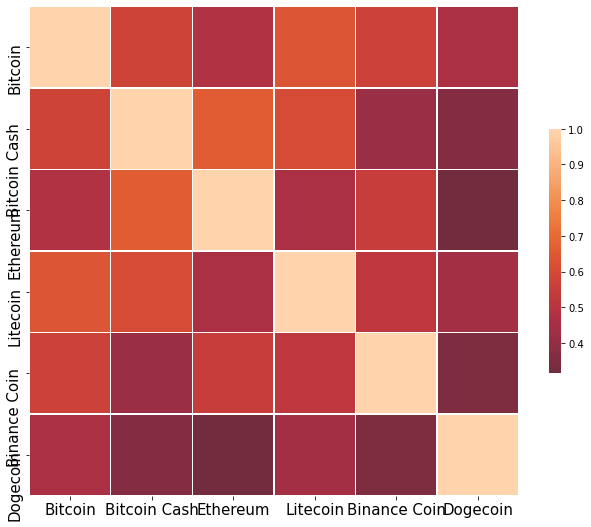

In [67]:
fig, ax = plt.subplots(figsize=(11, 9))
ax = sns.heatmap(corr,cbar_kws={"shrink": .5},linewidths=.5,square=True, center=0 )
ax.tick_params(labelsize=15)

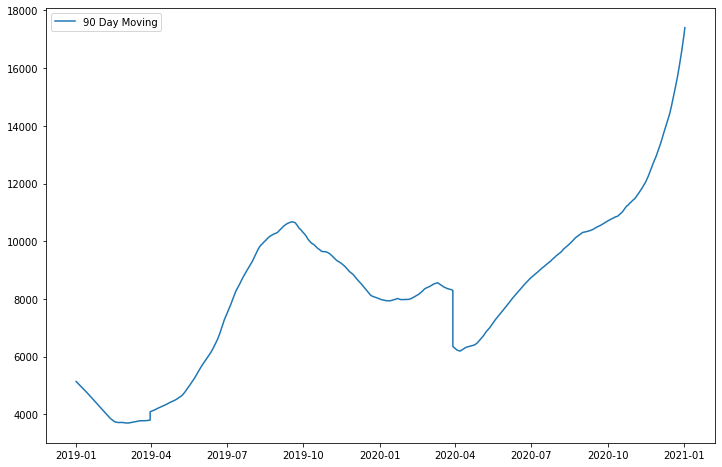

In [68]:
plt.figure(figsize=(12,8))
# plt.plot(moving30.loc['2019':]['Bitcoin'], label='30 Day Moving')
plt.plot(moving90.loc['2019':]['Bitcoin'], label='90 Day Moving')
# plt.plot(prices.loc['2019':]['Bitcoin'], label='Price')
plt.legend()

## Monte Carlo Simulation

In [69]:
def monte_carlo(log_ret, n_portfolios=5000):
    n_currencies = log_ret.shape[1]
    # Mean Log Return
    mean_log_ret = log_ret.mean()
    # Covariance Matrix
    sigma = log_ret.cov()
    # Weight Matrix
    all_weights = np.zeros((n_portfolios,n_currencies))
    # Expected Return array
    ret_arr = np.zeros(n_portfolios)
    # Expected Volatility array
    vol_arr = np.zeros(n_portfolios)
    # Sharpe Ratio array
    sharpe_arr = np.zeros(n_portfolios) 
    
    for k in range(n_portfolios):
        # Weights
        weights = np.array(np.random.random(n_currencies))
        weights = weights/np.sum(weights)
        # Save Weights
        all_weights[k,:] = weights
        # Expected Log Returns
        ret_arr[k] = np.sum(mean_log_ret * weights * 356)
        # expected volatility
        vol_arr[k] = np.sqrt(np.dot(weights.T, np.dot(sigma*365,weights)))
        #sharpe ratio
        sharpe_arr[k] = ret_arr[k]/vol_arr[k]
            
    return ret_arr, vol_arr, sharpe_arr, all_weights
 

In [70]:
ret_arr, vol_arr, sharpe_arr, best_weights = monte_carlo(log_ret, n_portfolios=5000)
max_index = sharpe_arr.argmax()

In [71]:
best_weights[max_index]

array([0.13195339, 0.01415234, 0.07942996, 0.0570759 , 0.69931468,
       0.01807374])

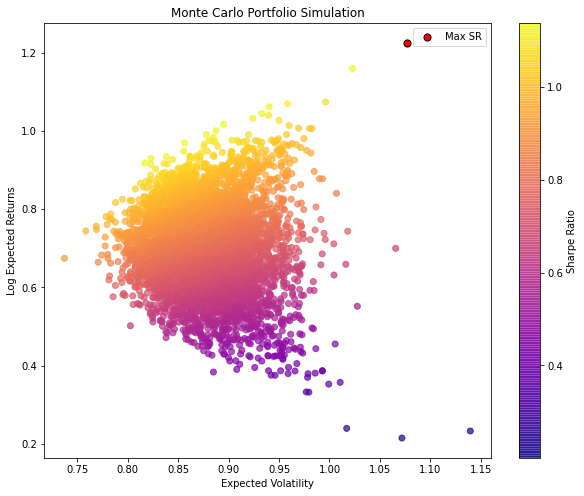

In [72]:
plt.figure(figsize=(10,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma', alpha=.7)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(vol_arr[max_index], 
            ret_arr[max_index], c='red', s=50, edgecolors='black', label='Max SR')
plt.xlabel('Expected Volatility')
plt.ylabel('Log Expected Returns')
plt.title('Monte Carlo Portfolio Simulation')
plt.legend()

## Optimization

In [73]:
def get_ret_vol_sr(weights):
    # Mean Log Return
    mean_log_ret = log_ret.mean()
    # Covariance Matrix
    sigma = log_ret.cov()
    
    weights = np.array(weights)
    ret = np.sum(mean_log_ret * weights) * 356
    vol = np.sqrt(np.dot(weights.T, np.dot(sigma*356, weights)))
    sr = ret/vol
    
    return np.array([ret,vol,sr])

In [74]:
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1

In [75]:
def check_sum(weights):
    # returns 0 if sum of the weights is 1
    return np.sum(weights) - 1 

In [76]:
n_currencies = prices.shape[1]
constraints = ({'type':'eq','fun':check_sum})
bounds = tuple([(0,1) for i in range(n_currencies)])
x0 = [1/n_currencies for i in range(n_currencies)]

In [77]:
options={'disp':True, 'return_all':True}

In [78]:
opt_results = minimize(neg_sharpe, x0, method='SLSQP', 
                       bounds=bounds, constraints=constraints)

In [79]:
opt_weights = list(opt_results.x)

In [80]:
[round(i,3) for i in opt_weights]

[0.395, 0.0, 0.142, 0.0, 0.463, 0.0]

In [81]:
get_ret_vol_sr(opt_results.x)

array([1.07517663, 0.8948898 , 1.2014626 ])

<BarContainer object of 6 artists>

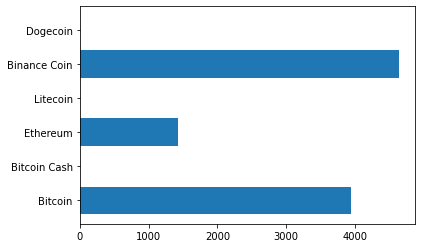

In [82]:
#monte carlo
y = [i*10000 for i in list(opt_results.x)]
x = list(tickers.keys())
plt.barh(x,y)

<BarContainer object of 6 artists>

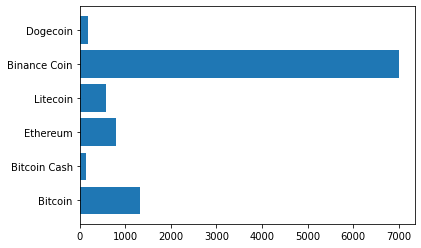

In [83]:
#optimization
y = [i*10000 for i in list(best_weights[max_index])]
x = list(tickers.keys())
plt.barh(x,y)

### Efficient Frontier

In [84]:
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [85]:
frontier_y = np.linspace(0, 0.6, 50)
frontier_volatility = []

for possible_return in frontier_y:
    constraints = ({'type':'eq', 'fun': check_sum}, 
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    result = minimize(minimize_volatility, x0,  method='SLSQP', 
                       bounds=bounds, constraints=constraints)
    frontier_volatility.append(result['fun'])

Text(0.5, 1.0, 'Efficient Frontier')

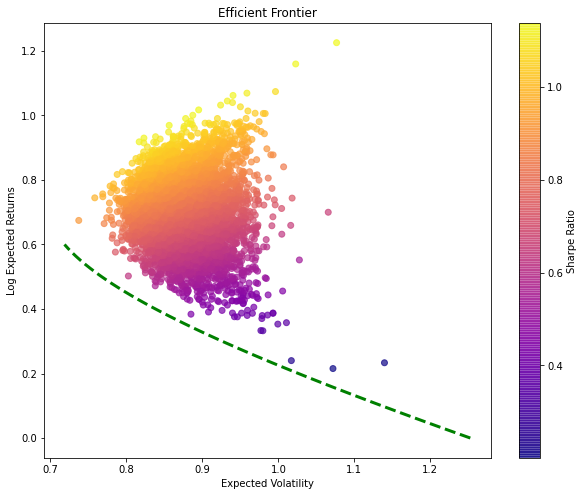

In [86]:
plt.figure(figsize=(10,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma', alpha=.7)
plt.colorbar(label='Sharpe Ratio')
# plt.scatter(vol_arr[max_index], 
#             ret_arr[max_index], c='red', s=50, edgecolors='black', label='Max SR')
plt.plot(frontier_volatility, frontier_y, 'g--', linewidth=3)

plt.xlabel('Expected Volatility')
plt.ylabel('Log Expected Returns')
plt.title('Efficient Frontier')